# Семинар 10: Метод опорных векторов (Support vector machine). Ядерные методы (Kernel methods).

In [2]:
import numpy as np

import sklearn
import sys
import os

np.random.seed(42)

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rc('axes' , labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## Мотивация метода

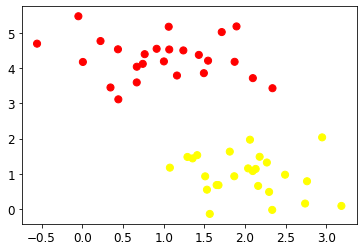

In [3]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=50, centers=2, random_state = 0, cluster_std=0.60)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

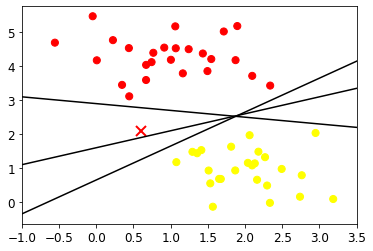

In [4]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

### Максимизация *зазора* (margin)

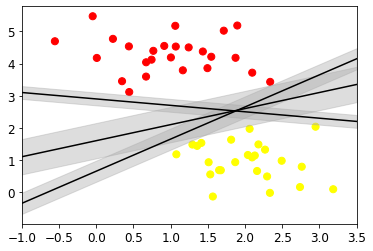

In [5]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

### Функция потерь для задачи регрессии

$$L_{\epsilon}(y,\tilde{y})=\begin{cases} 0, & if |y - \tilde{y}| < \epsilon \\ |y - \tilde{y}| - \epsilon , & otherwise \end{cases}$$
$$J=C\sum_{i=1}^{N} L_{\epsilon}(y,\tilde{y}) + \frac{1}{2}\|w\|^2$$

### Функция потерь для задачи классификации

$$L_{hinge}(y,\eta)=max(0,1 - y\eta) = (0,1 - y\eta)_{+}, \eta=f(x)$$
$$J=C\sum_{i=1}^{N} (1-y_if(x_i))_{+} + \frac{1}{2}\|w\|^2)$$

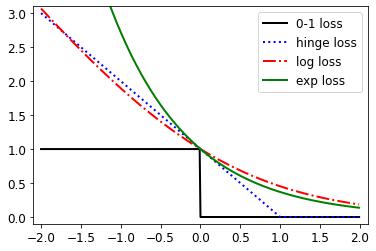

In [6]:
zeroOne = np.vectorize(lambda x: 1 * (x <= 0))
hinge   = np.vectorize(lambda x: max(0, 1 - x))
logLoss = np.vectorize(lambda x: np.log2(1 + np.exp(-x)))
expLoss = np.vectorize(lambda x: np.exp(-x))

funs   = [zeroOne, hinge, logLoss, expLoss]
styles = ["k-", "b:", "r-.", "g-"]
labels = ["0-1 loss", "hinge loss", "log loss", "exp loss"]
x      = np.arange(-2, 2, 0.01)

for i, fun in enumerate(funs):
    plt.plot(x, fun(x), styles[i], label=labels[i], linewidth=2)

plt.axis([-2.1, 2.1, -0.1, 3.1])
plt.legend(fontsize=12)
plt.show()

### Настройка метода опорных векторов

Посмотрим на результат подгонки данных: с помощью классификатора опорных векторов Scikit-Learn мы обучим SVM-модель на этих данных.
Пока мы будем использовать линейное ядро и установим очень большое значение параметра ``C`` о значениях этих параметров поговорим позже.

In [7]:
from sklearn.svm import SVC

model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, kernel='linear')

In [8]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

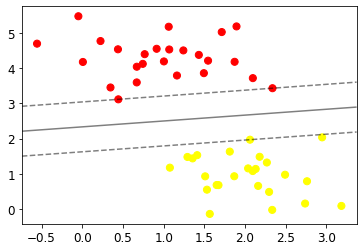

In [9]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

Это граница, которая максимизирует разницу между двумя наборами точек. Обратите внимание, что несколько обучающих точек касаются границы: они обозначены черными кружками на этом рисунке.
Эти точки являются ключевыми элементами данной подгонки и называются *опорными векторами*, что и дало название методу. В Scikit-Learn идентификаторы этих точек хранятся в атрибуте ``support_vectors_`` классификатора.

In [10]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

Важным преимуществом этого классификатора является то, что для подгонки имеет значение только положение опорных векторов; любые точки, расположенные дальше от границы и находящиеся на правильной стороне, не изменяют подгонку! Технически это объясняется тем, что эти точки не вносят вклад в функцию потерь, используемую для подгонки модели, поэтому их положение и количество не имеют значения до тех пор, пока они не пересекают границу. Это можно увидеть, например, если построить график модели, построенной по первым 60 и первым 120 точкам данного набора данных:

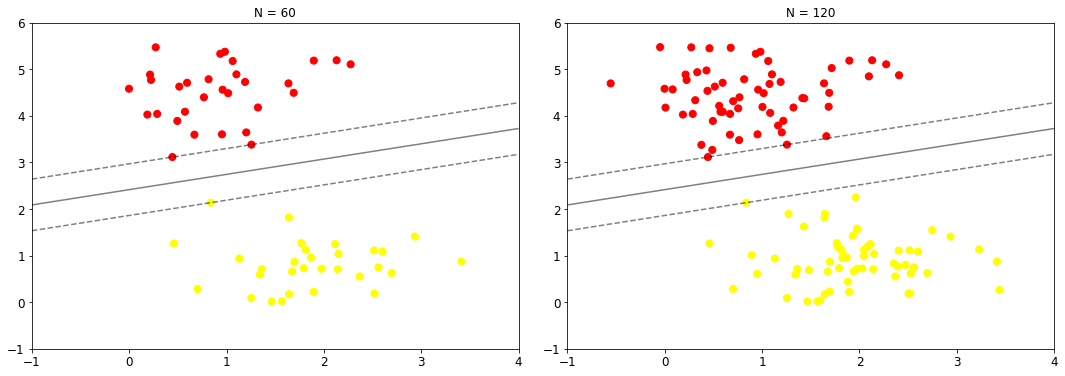

In [11]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2, random_state=0, cluster_std=0.60)
    X, y = X[:N], y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

In [12]:
from ipywidgets import interact, fixed
interact(plot_svm, N=[10, 50, 100, 200], ax=fixed(None));

interactive(children=(Dropdown(description='N', options=(10, 50, 100, 200), value=10), Output()), _dom_classes…

### Настройка SVM: cмягчение границ

До сих пор мы обсуждали очень чистые наборы данных, в которых существует четкая граница принятия решений. Но что делать, если ваши данные имеют некоторое перекрытие? Например, у вас могут быть такие данные:

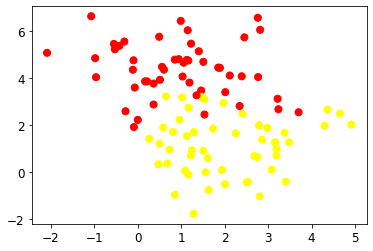

In [13]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

Чтобы справиться с этой проблемой, в реализации SVM имеется некоторый коэффициент, который `смягчает` границы: то есть позволяет некоторым точкам заходить за границы, если это дает лучшее соответствие.
Жесткость поля регулируется параметром настройки, чаще всего известным как $C$. При очень больших $C$ край жесткий, и точки не могут в нем лежать.
При меньшем значении $C$ граница становится более мягкой и может увеличиваться, охватывая некоторые точки. Приведенный ниже график дает наглядное представление о том, как изменение параметра $C$ влияет на конечную подгонку, смягчая границы:

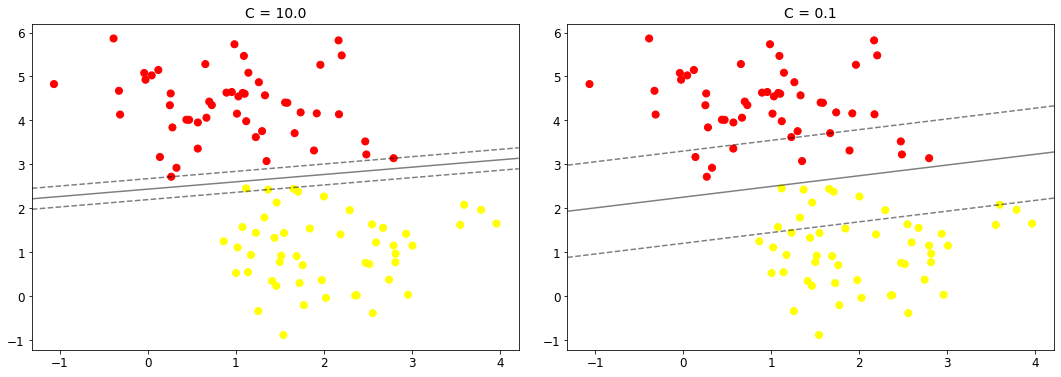

In [14]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)

Оптимальное значение параметра $C$ зависит от набора данных и должно быть подобрано с помощью перекрестной валидации или аналогичной процедуры.

## Метод опорных векторов в задаче классификации

In [15]:
from sklearn.svm import SVC
from sklearn import datasets

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

# SVM Classifier model
svm_clf = SVC(kernel="linear", C=1.0)
svm_clf.fit(X, y)

SVC(kernel='linear')

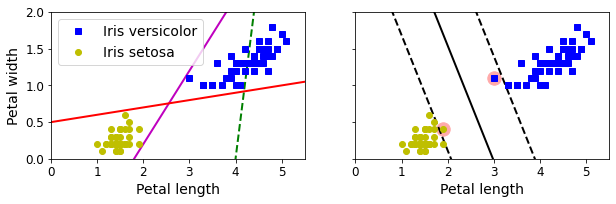

In [16]:
# Bad models
x0 = np.linspace(0, 5.5, 200)
pred_1 = 5*x0 - 20
pred_2 = x0 - 1.8
pred_3 = 0.1 * x0 + 0.5

def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up   = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

fig, axes = plt.subplots(ncols=2, figsize=(10,2.7), sharey=True)

plt.sca(axes[0])
plt.plot(x0, pred_1, "g--", linewidth=2)
plt.plot(x0, pred_2, "m-", linewidth=2)
plt.plot(x0, pred_3, "r-", linewidth=2)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 5.5, 0, 2])

plt.sca(axes[1])
plot_svc_decision_boundary(svm_clf, 0, 5.5)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.xlabel("Petal length", fontsize=14)
plt.axis([0, 5.5, 0, 2])

plt.show()

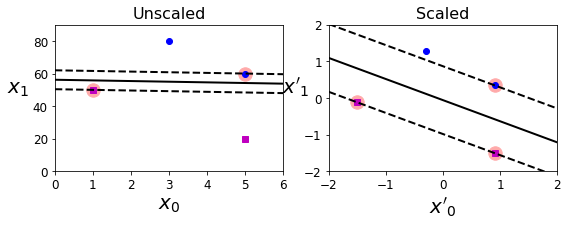

In [17]:
Xs = np.array([[1, 50], [5, 20], [3, 80], [5, 60]]).astype(np.float64)
ys = np.array([0, 0, 1, 1])
svm_clf = SVC(kernel="linear", C=100)
svm_clf.fit(Xs, ys)

plt.figure(figsize=(9,2.7))
plt.subplot(121)
plt.plot(Xs[:, 0][ys==1], Xs[:, 1][ys==1], "bo")
plt.plot(Xs[:, 0][ys==0], Xs[:, 1][ys==0], "ms")
plot_svc_decision_boundary(svm_clf, 0, 6)
plt.xlabel("$x_0$", fontsize=20)
plt.ylabel("$x_1$    ", fontsize=20, rotation=0)
plt.title("Unscaled", fontsize=16)
plt.axis([0, 6, 0, 90])

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(Xs)
svm_clf.fit(X_scaled, ys)

plt.subplot(122)
plt.plot(X_scaled[:, 0][ys==1], X_scaled[:, 1][ys==1], "bo")
plt.plot(X_scaled[:, 0][ys==0], X_scaled[:, 1][ys==0], "ms")
plot_svc_decision_boundary(svm_clf, -2, 2)
plt.xlabel("$x'_0$", fontsize=20)
plt.ylabel("$x'_1$  ", fontsize=20, rotation=0)
plt.title("Scaled", fontsize=16)
plt.axis([-2, 2, -2, 2])
plt.show()

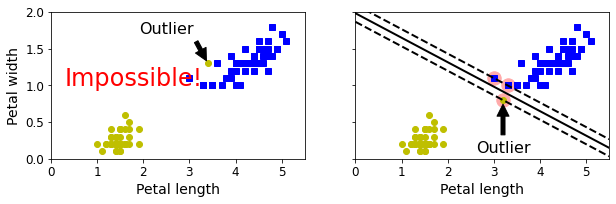

In [18]:
X_outliers = np.array([[3.4, 1.3], [3.2, 0.8]])
y_outliers = np.array([0, 0])
Xo1 = np.concatenate([X, X_outliers[:1]], axis=0)
yo1 = np.concatenate([y, y_outliers[:1]], axis=0)
Xo2 = np.concatenate([X, X_outliers[1:]], axis=0)
yo2 = np.concatenate([y, y_outliers[1:]], axis=0)

svm_clf2 = SVC(kernel="linear", C=10**9)
svm_clf2.fit(Xo2, yo2)

fig, axes = plt.subplots(ncols=2, figsize=(10,2.7), sharey=True)

plt.sca(axes[0])
plt.plot(Xo1[:, 0][yo1==1], Xo1[:, 1][yo1==1], "bs")
plt.plot(Xo1[:, 0][yo1==0], Xo1[:, 1][yo1==0], "yo")
plt.text(0.3, 1.0, "Impossible!", fontsize=24, color="red")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.annotate("Outlier",
             xy=(X_outliers[0][0], X_outliers[0][1]),
             xytext=(2.5, 1.7),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=16,
            )
plt.axis([0, 5.5, 0, 2])

plt.sca(axes[1])
plt.plot(Xo2[:, 0][yo2==1], Xo2[:, 1][yo2==1], "bs")
plt.plot(Xo2[:, 0][yo2==0], Xo2[:, 1][yo2==0], "yo")
plot_svc_decision_boundary(svm_clf2, 0, 5.5)
plt.xlabel("Petal length", fontsize=14)
plt.annotate("Outlier",
             xy=(X_outliers[1][0], X_outliers[1][1]),
             xytext=(3.2, 0.08),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=16,
            )
plt.axis([0, 5.5, 0, 2])
plt.show()

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline      import Pipeline
from sklearn.svm           import LinearSVC

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.float64)  # Iris virginica

svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("linear_svc", LinearSVC(C=1, loss="hinge", random_state=42)),
    ])

svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc', LinearSVC(C=1, loss='hinge', random_state=42))])

In [20]:
svm_clf.predict([[5.5, 1.7]])

array([1.])

In [21]:
scaler = StandardScaler()
svm_clf1 = LinearSVC(C=1  , loss="hinge", random_state=42)
svm_clf2 = LinearSVC(C=100, loss="hinge", random_state=42)

scaled_svm_clf1 = Pipeline([
        ("scaler", scaler),
        ("linear_svc", svm_clf1),
    ])
scaled_svm_clf2 = Pipeline([
        ("scaler", scaler),
        ("linear_svc", svm_clf2),
    ])

scaled_svm_clf1.fit(X, y)
scaled_svm_clf2.fit(X, y)

/home/sergey/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc',
                 LinearSVC(C=100, loss='hinge', random_state=42))])

In [22]:
# Convert to unscaled parameters
b1 = svm_clf1.decision_function([-scaler.mean_ / scaler.scale_])
b2 = svm_clf2.decision_function([-scaler.mean_ / scaler.scale_])
w1 = svm_clf1.coef_[0] / scaler.scale_
w2 = svm_clf2.coef_[0] / scaler.scale_
svm_clf1.intercept_ = np.array([b1])
svm_clf2.intercept_ = np.array([b2])
svm_clf1.coef_ = np.array([w1])
svm_clf2.coef_ = np.array([w2])

# Find support vectors (LinearSVC does not do this automatically)
t = y * 2 - 1
support_vectors_idx1 = (t * (X.dot(w1) + b1) < 1).ravel()
support_vectors_idx2 = (t * (X.dot(w2) + b2) < 1).ravel()
svm_clf1.support_vectors_ = X[support_vectors_idx1]
svm_clf2.support_vectors_ = X[support_vectors_idx2]

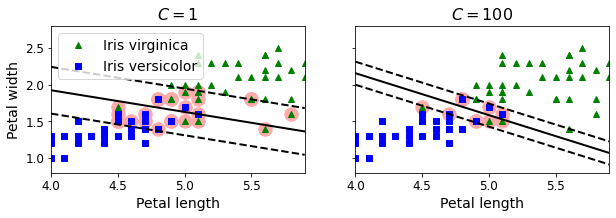

In [23]:
fig, axes = plt.subplots(ncols=2, figsize=(10,2.7), sharey=True)

plt.sca(axes[0])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^", label="Iris virginica")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", label="Iris versicolor")
plot_svc_decision_boundary(svm_clf1, 4, 5.9)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.title("$C = {}$".format(svm_clf1.C), fontsize=16)
plt.axis([4, 5.9, 0.8, 2.8])

plt.sca(axes[1])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plot_svc_decision_boundary(svm_clf2, 4, 5.99)
plt.xlabel("Petal length", fontsize=14)
plt.title("$C = {}$".format(svm_clf2.C), fontsize=16)
plt.axis([4, 5.9, 0.8, 2.8])
plt.show()

## Метод опорных векторов в задаче регрессии

In [24]:
np.random.seed(42)
m = 50
X = 2 * np.random.rand(m, 1)
y = (4 + 3 * X + np.random.randn(m, 1)).ravel()

In [25]:
from sklearn.svm import LinearSVR

svm_reg = LinearSVR(epsilon=1.5, random_state=42)
svm_reg.fit(X, y)

LinearSVR(epsilon=1.5, random_state=42)

In [26]:
svm_reg1 = LinearSVR(epsilon=1.5, random_state=42)
svm_reg2 = LinearSVR(epsilon=0.5, random_state=42)
svm_reg1.fit(X, y)
svm_reg2.fit(X, y)

def find_support_vectors(svm_reg, X, y):
    y_pred = svm_reg.predict(X)
    off_margin = (np.abs(y - y_pred) >= svm_reg.epsilon)
    return np.argwhere(off_margin)

svm_reg1.support_ = find_support_vectors(svm_reg1, X, y)
svm_reg2.support_ = find_support_vectors(svm_reg2, X, y)

eps_x1 = 1
eps_y_pred = svm_reg1.predict([[eps_x1]])

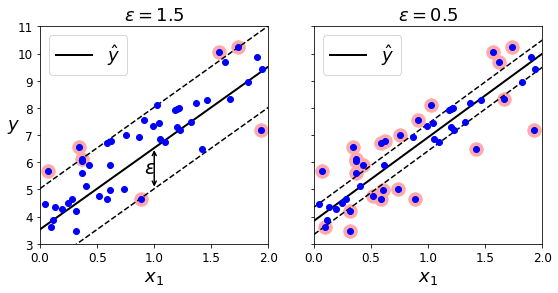

In [27]:
def plot_svm_regression(svm_reg, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$")
    plt.plot(x1s, y_pred + svm_reg.epsilon, "k--")
    plt.plot(x1s, y_pred - svm_reg.epsilon, "k--")
    plt.scatter(X[svm_reg.support_], y[svm_reg.support_], s=180, facecolors='#FFAAAA')
    plt.plot(X, y, "bo")
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.legend(loc="upper left", fontsize=18)
    plt.axis(axes)

fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_reg1, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
#plt.plot([eps_x1, eps_x1], [eps_y_pred, eps_y_pred - svm_reg1.epsilon], "k-", linewidth=2)
plt.annotate(
        '', xy=(eps_x1, eps_y_pred), xycoords='data',
        xytext=(eps_x1, eps_y_pred - svm_reg1.epsilon),
        textcoords='data', arrowprops={'arrowstyle': '<->', 'linewidth': 1.5}
    )
plt.text(0.91, 5.6, r"$\epsilon$", fontsize=20)
plt.sca(axes[1])
plot_svm_regression(svm_reg2, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg2.epsilon), fontsize=18)
plt.show()

## Ядерные методы

## Теорема Ковера (Cover's theorem)
Является утверждением в теория вычислительного обучения и является одним из основных теоретических мотивов использования нелинейных методов ядра в приложениях машинного обучения . Теорема утверждает, что для данного набора обучающих данных, который не является линейно разделимым , можно с высокой вероятностью преобразовать его в обучающий набор, который линейно разделяется, проецируя его в многомерное пространство через некоторые преобразования.

![](images/example.png)

Как следствие теорема говорит о том, что если взять свой набор данных и преобразовать эти точки в пространство более высокой размерности, то возможно построить модель линейной классификации (классификатор). Однако большинство классификаторов должны вычислять некоторое подобие, например, точечное произведение, а это означает, что временная сложность алгоритма классификации пропорциональна размерности точки данных. Таким образом, большая размерность означает большую временную сложность (не говоря уже о сложности хранения точек большой размерности).

### Ядерные методы (Kernel trick)

Пусть $M$ исходная размерность точек данных, а f - преобразование, отображающее эти точки в пространство размерности $N(>>M)$. Теперь, если существует функция K, которая принимает входные данные x и y из исходного пространства и вычисляет $K(x,y)=⟨f(x),f(y)⟩$, то я могу вычислить точечное произведение в пространстве более высокой размерности, но со сложностью $O(M)$ вместо $O(N)$.


### Линейные ядра

$$k(x, x') = \phi(x)^{T}\phi(x^{'})$$


### Ядро RBF (Radial Basis Function)

$$k(x, x') = exp(-\frac{1}{2}(x-x')\Sigma^{-1}(x-x'))$$

, если матрица $\Sigma$ диагональная

$$k(x, x') = exp(-\frac{1}{2}\Sigma_{i=1}^{D}\frac{1}{\sigma_i^2}(x-x')^2)$$

, если $\Sigma$ диагональная и изотропная

$$k(x, x') = exp(-\frac{1}{2{\sigma}^2} \|x - x' \|^2   )$$


### Ядра Мерсера (Mercer kernel)

Преобразование можно представить следующей матрицей Грамма

$$K(x, x') = 
\begin{pmatrix}
k(x_1, x_1') & \ldots & k(x_1, x_N')\\
 & \vdots  & \\
k(x_N, x_1') & \ldots & k(x_N, x_N')
\end{pmatrix}$$

, преобразования является положительно определенным, следовательно

$$
K=U^{\top}{\Lambda}U \Rightarrow k_{i,j}=(\Lambda^{1/2}U_{:,i})^{\top}(\Lambda^{1/2}U_{:,j})
$$

, если ввести обозначение $\phi(x_i) = \Lambda^{1/2}U_{:,i}$, тогда

$$
k_{i,j} = \phi(x_i)^{\top}\phi(x_j) \Rightarrow k(x,x')=\phi(x)^{\top}\phi(x')
$$

Полиномиальное ядро (polynomial kernel)

$$k(x,x')=({\gamma}x^{\top}x' + r)^{M}, r > 0$$

Расcмотрим полиномиальное ядро при $M=2, \gamma=r=1$ и $x, x' \in R^2$

$$
(1 + x^{\top}{x'})^2 = (1 + {x_1}{x'_1} + {x_2}{x'_2})^2 = 1 + 2{x_1}{x'_1} + 2{x_2}{x'_2} + ({x_1}{x'_1})^2 + ({x_2}{x'_2})^2 + {x_1}{x'_1}{x_2}{x'_2}
$$

тогда 

$$
\phi(x) = [1, \sqrt{2}x_1, \sqrt{2}x_2, x_1^{2}, x_2^{2}, \sqrt{2}x_1x_2]^{\top}
$$

Где мы встречались с таким преобразованием исходных признаков?

### Пример задачи классификации

In [34]:
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

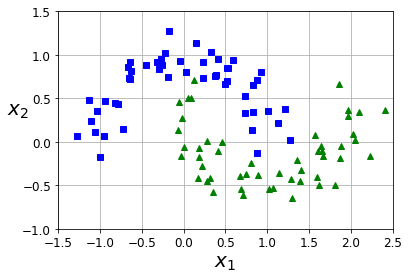

In [35]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

In [50]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline      import Pipeline

polynomial_svm_clf = Pipeline([
        ("poly_features", PolynomialFeatures(degree=3)),
        ("scaler", StandardScaler()),
        ("svm_clf", LinearSVC(C=10, loss="hinge", max_iter=10000, random_state=42))
    ])

polynomial_svm_clf.fit(X, y)

Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('scaler', StandardScaler()),
                ('svm_clf',
                 LinearSVC(C=10, loss='hinge', max_iter=10000,
                           random_state=42))])

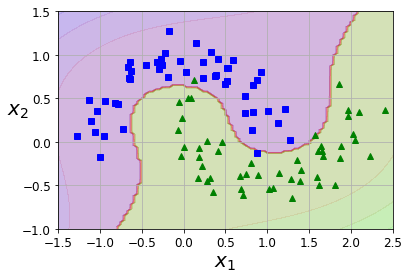

In [51]:
plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

In [52]:
poly_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
    ])
poly_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=5, coef0=1, kernel='poly'))])

In [43]:
poly100_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=10, coef0=100, C=5))
    ])
poly100_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=5, coef0=100, degree=10, kernel='poly'))])

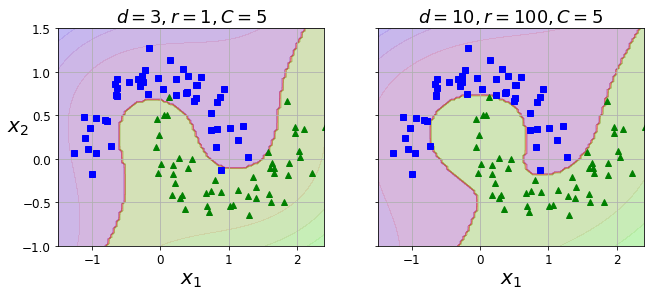

In [44]:
fig, axes = plt.subplots(ncols=2, figsize=(10.5, 4), sharey=True)

plt.sca(axes[0])
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title(r"$d=3, r=1, C=5$", fontsize=18)

plt.sca(axes[1])
plot_predictions(poly100_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title(r"$d=10, r=100, C=5$", fontsize=18)
plt.ylabel("")

plt.show()

In [53]:
rbf_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="rbf", gamma=5, C=0.001))
    ])
rbf_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=0.001, gamma=5))])

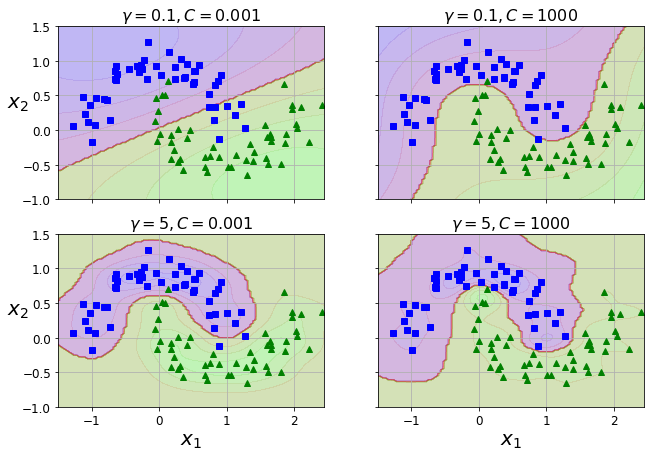

In [54]:
gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = Pipeline([
            ("scaler", StandardScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=gamma, C=C))
        ])
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10.5, 7), sharex=True, sharey=True)

for i, svm_clf in enumerate(svm_clfs):
    plt.sca(axes[i // 2, i % 2])
    plot_predictions(svm_clf, [-1.5, 2.45, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.45, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(r"$\gamma = {}, C = {}$".format(gamma, C), fontsize=16)
    if i in (0, 1):
        plt.xlabel("")
    if i in (1, 3):
        plt.ylabel("")

plt.show()

### Пример задачи регрессии

In [61]:
def plot_svm_regression(svm_reg, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$")
    plt.plot(x1s, y_pred + svm_reg.epsilon, "k--")
    plt.plot(x1s, y_pred - svm_reg.epsilon, "k--")
    plt.scatter(X[svm_reg.support_], y[svm_reg.support_], s=180, facecolors="#FFAAAA")
    plt.plot(X, y, "bo")
    plt.xlabel(r"$x_1$", fontsize=18)
    # plt.legend(loc="upper left", fontsize=18)
    plt.axis(axes)

In [62]:
np.random.seed(42)
m = 100
X = 2 * np.random.rand(m, 1) - 1
y = (0.2 + 0.1 * X + 0.5 * X**2 + np.random.randn(m, 1)/10).ravel()

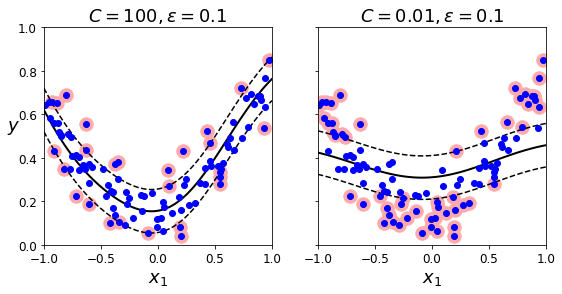

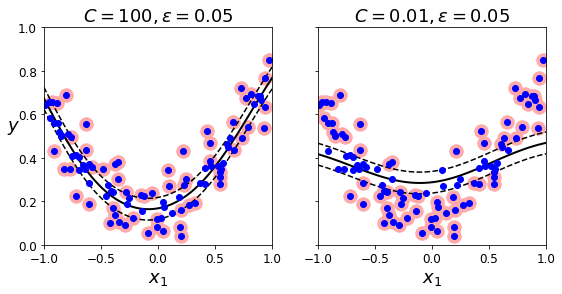

In [63]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

from sklearn.svm import LinearSVR
from sklearn.svm import SVR

epsilons = [0.1, 0.05]
eps_names = ["0p1", "0p05"]
for i, eps in enumerate(epsilons):
    # svm_poly_reg1 = SVR(kernel="poly", degree=5, C=1e3, epsilon=eps, gamma="scale")
    # svm_poly_reg2 = SVR(kernel="poly", degree=5, C=1e-3, epsilon=eps, gamma="scale")
    svm_reg1 = SVR(kernel="rbf", gamma=1, C=100 , epsilon=eps)
    svm_reg2 = SVR(kernel="rbf", gamma=1, C=0.01, epsilon=eps)

    svm_reg1.fit(X, y)
    svm_reg2.fit(X, y)

    fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
    plt.sca(axes[0])
    plot_svm_regression(svm_reg1, X, y, [-1, 1, 0, 1])
    plt.title(r"$C={}, \epsilon = {}$".format(svm_reg1.C, svm_reg1.epsilon), fontsize=18)
    plt.ylabel(r"$y$", fontsize=18, rotation=0)
    plt.sca(axes[1])
    plot_svm_regression(svm_reg2, X, y, [-1, 1, 0, 1])
    plt.title(r"$C={}, \epsilon = {}$".format(svm_reg2.C, svm_reg2.epsilon), fontsize=18)
    fname = "figures/svm_regression_e{}.pdf".format(eps_names[i])
    #plt.savefig(fname, dpi=300)
    plt.show()

## Краткое описание метода опорных векторов

Мы рассмотрели интуитивное введение в принципы метода опорных векторов.
Эти методы являются мощными методами классификации и регрессии по ряду причин:

- Их зависимость от относительно небольшого числа опорных векторов означает, что они являются очень компактными моделями и занимают очень мало памяти.
- После обучения модели этап прогнозирования выполняется очень быстро.
- Поскольку на модель влияют только точки вблизи границы, она хорошо работает с высокоразмерными данными - даже с данными, у которых размерность больше, чем количество выборок, что является сложным режимом для других алгоритмов.
- Интеграция с ядерными методами делает их очень универсальными, способными адаптироваться ко многим типам данных.

Однако SVM имеют и ряд недостатков:

- Масштабирование с числом выборок $N$ составляет $\mathcal{O}[N^3]$ в худшем случае или $\mathcal{O}[N^2]$ для эффективных реализаций. Для большого числа обучающих выборок эти вычислительные затраты могут оказаться непомерно высокими.
- Результаты сильно зависят от подходящего выбора параметра сглаживания $C$. Его необходимо тщательно подбирать с помощью кросс-валидации, которая может оказаться дорогостоящей при увеличении размера набора данных.
- Результаты не имеют прямой вероятностной интерпретации. Ее можно оценить с помощью внутренней кросс-валидации (см. параметр ``вероятность`` в ``SVC''), но эта дополнительная оценка требует больших затрат.